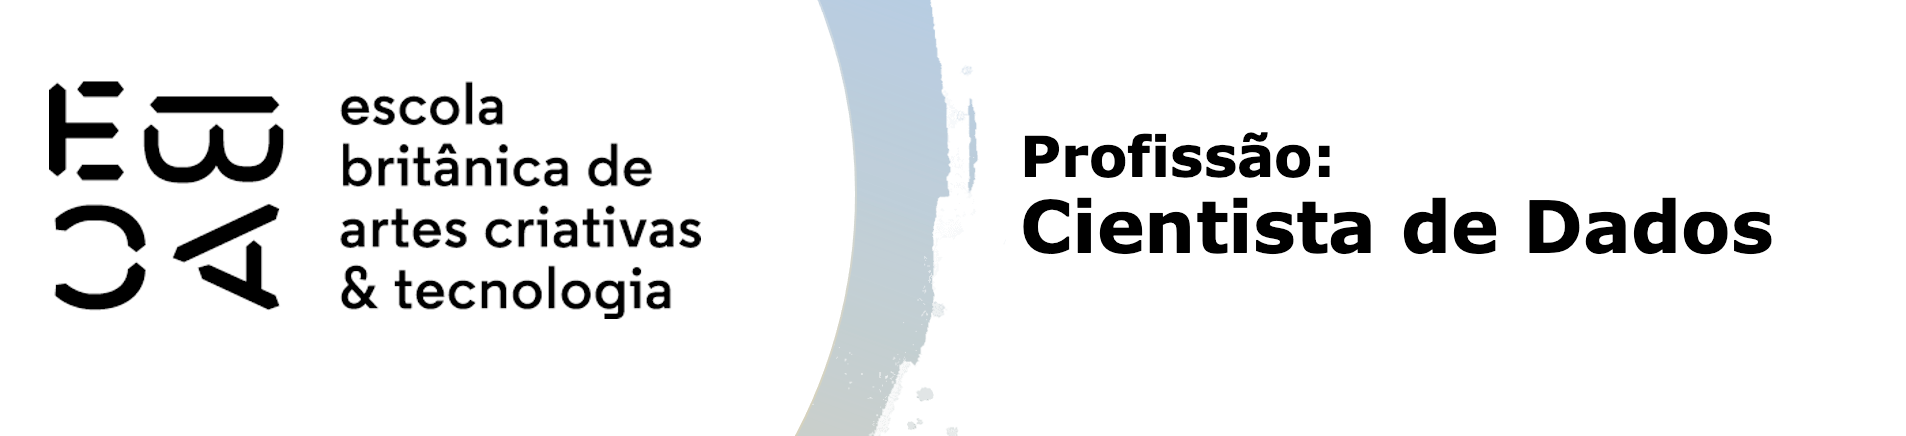

# Regressão III

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels.api            import add_constant
from scipy.interpolate          import interp1d
from sklearn.model_selection    import train_test_split
from sklearn.linear_model       import LinearRegression
from sklearn.metrics            import r2_score

In [2]:
df = pd.read_csv(r'Dados\previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [3]:
valores_miss = df.isnull().sum()
valores_miss

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
# Como é possivel observarsomente a coluna contendo o tempo de emprego possui valores faltantes, portanto serão substituidos somente nessa coluna.
# Inicialmente é calculado a média dos valores da coluna.
media_tempo_emprego = df['tempo_emprego'].mean()

# Após o calculo, podemos realizar a susbtituição dos valores faltantes
df['tempo_emprego'] = df['tempo_emprego'].fillna(media_tempo_emprego)

# Ao avaliar o dataframe, foi possivel observar que na variavel alvo "renda" existem alguns outliears muito significativos
# Para remover esses outliers, irei determinar um valor de limite superior para a variavel alvo "renda", correspondendo a 1% mais alto
limite_superior = df['renda'].quantile(0.99)
print(limite_superior)

# Ao realizar o filtro, irei remover os valores maiores que o limite superior
df = df[df['renda'] < limite_superior]

df.head()

295197.32


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [5]:
# Para poder utilizar todas as variaveis do df, 
df_dummies = pd.get_dummies(df, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])
df_dummies.head()

,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,,,
2015-01-01,5762,0,47,16.717808,2.0,11138.14,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
2015-01-01,1279,0,30,9.600000,2.0,2424.81,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
2015-01-01,14111,0,28,8.208219,2.0,13749.66,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
2015-01-01,8189,2,44,1.301370,4.0,2361.84,False,True,True,False,...,False,False,False,False,False,True,False,False,False,False
2015-01-01,1830,2,33,1.254795,4.0,790.78,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False


In [6]:
# Para poder realizar manipulações com datas, primeiro certifico que a coluna de data esta no formato datetime
df_dummies.index = pd.to_datetime(df_dummies.index)

# Para poder serparar a base dos ultimos 3 meses, é mais simples e generalista identificar a maior data presente no df e separar os ultimos 3 meses
maior_data = df_dummies.index.max()

# Separando os ultimos 3 meses
data_3meses = maior_data - pd.DateOffset(months=3)

# Separação das bases de teste e treino
base_treino = df_dummies[df_dummies.index < data_3meses]
base_teste = df_dummies[df_dummies.index >= data_3meses]

print(base_treino.head())
print(base_teste.head())

            index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
data_ref                                                                     
2015-01-01   5762           0     47      16.717808                    2.0   
2015-01-01   1279           0     30       9.600000                    2.0   
2015-01-01  14111           0     28       8.208219                    2.0   
2015-01-01   8189           2     44       1.301370                    4.0   
2015-01-01   1830           2     33       1.254795                    4.0   

               renda  sexo_F  sexo_M  posse_de_veiculo_N  posse_de_veiculo_S  \
data_ref                                                                       
2015-01-01  11138.14   False    True               False                True   
2015-01-01   2424.81   False    True               False                True   
2015-01-01  13749.66   False    True               False                True   
2015-01-01   2361.84   False    True                T

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [7]:
# Dados de treino
X_treino = base_treino.drop(columns=['renda', 'index'])
y_treino = base_treino['renda']

# Dados de teste
X_teste = base_teste.drop(columns=['renda', 'index'])
y_teste = base_teste['renda']

In [8]:
# Criando o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

# Previsões
y_pred_treino = modelo.predict(X_treino)
y_pred_teste = modelo.predict(X_teste)

# Para calcular o R² ajustado é necessário calcular o R² antes
r2_treino = r2_score(y_treino, y_pred_treino)
r2_teste = r2_score(y_teste, y_pred_teste)

# Antes do calculo do R² ajustado é necessário determinar o numero de observações e de regressores
n = len(X_treino)
k = X_treino.shape[1]

# Por fim, calcular o R² ajustado com base nos calculos
r2_ajus_treino = 1 - (1 - r2_treino) * (n - 1) / (n - k - 1)
r2_ajus_teste = 1 - (1 - r2_teste) * (n - 1) / (n - k - 1)

# Imprimindo os resultados
print('R² de treino:', r2_treino)
print('R² de teste:', r2_teste)
print('R² ajustado de treino:', r2_ajus_treino)
print('R² ajustado de teste:', r2_ajus_teste)

R² de treino: 0.4175230036432668
R² de teste: -0.6092082874274465
R² ajustado de treino: 0.41748973868125006
R² ajustado de teste: -0.6093001884860172


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [9]:
# Calcular os quantis para a variável 'tempo_emprego'
quantis_tempo_emprego = pd.qcut(df['tempo_emprego'], q=20, duplicates='drop')

# Categorizar a variável 'tempo_emprego' com base nos quantis calculados
df['categoria_tempo_emprego'] = quantis_tempo_emprego

# Calcular a média do log-renda para cada categoria
df['log_renda'] = np.log(df['renda'])  # Calcular o log-renda
perfil = df.groupby('categoria_tempo_emprego').agg({'categoria_tempo_emprego': 'count', 'log_renda': 'mean', 'tempo_emprego': 'mean'})

# Renomear as colunas
perfil.columns = ['quantidade_observacoes', 'media_log_renda', 'media_tempo_emprego']

# Exibir a tabela de perfil
print(perfil)

                              quantidade_observacoes  media_log_renda  \
categoria_tempo_emprego                                                 
(0.11699999999999999, 0.808]                   37369         8.131940   
(0.808, 1.433]                                 37069         8.221100   
(1.433, 2.074]                                 36950         8.328811   
(2.074, 2.879]                                 37454         8.386554   
(2.879, 3.622]                                 36892         8.516810   
(3.622, 4.266]                                 37323         8.616138   
(4.266, 4.882]                                 36991         8.661081   
(4.882, 5.693]                                 37014         8.797013   
(5.693, 6.545]                                 37284         8.904875   
(6.545, 7.389]                                 37078         8.974831   
(7.389, 7.746]                                140200         8.820561   
(7.746, 7.948]                                  820

C:\Users\Rafael\AppData\Local\Temp\ipykernel_23148\2942095014.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perfil = df.groupby('categoria_tempo_emprego').agg({'categoria_tempo_emprego': 'count', 'log_renda': 'mean', 'tempo_emprego': 'mean'})


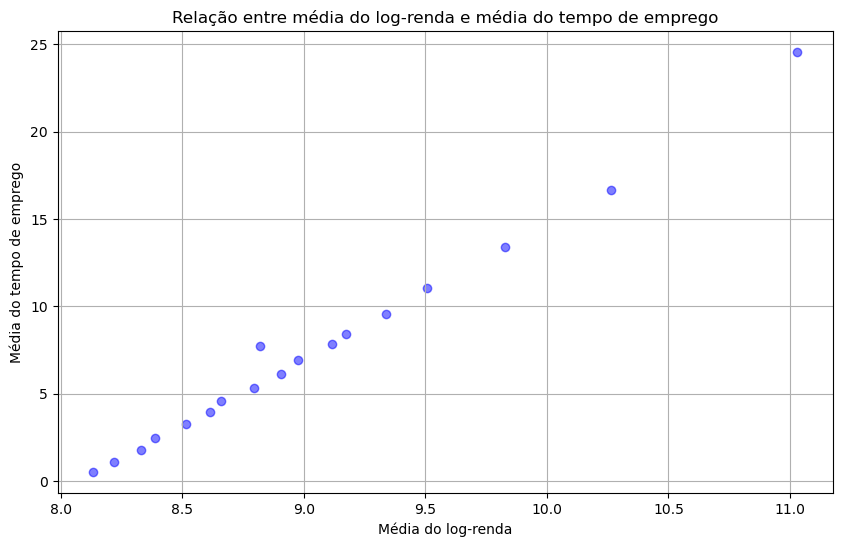

In [10]:
# Extrair os dados
media_tempo_emprego = perfil['media_tempo_emprego']
media_log_renda = perfil['media_log_renda']

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(media_log_renda, media_tempo_emprego, color='blue', alpha=0.5)

# Adicionar rótulos e título
plt.xlabel('Média do log-renda')
plt.ylabel('Média do tempo de emprego')
plt.title('Relação entre média do log-renda e média do tempo de emprego')

# Exibir o gráfico
plt.grid(True)
plt.show()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


### Linearização utilizando LOWESS 

In [11]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.renda, df.tempo_emprego, frac=2/3)

In [12]:
# Valores de Y suavizados
lowess_renda = lowess[:, 1]
lowess_tempo_emprego = lowess[:, 0]

In [13]:
# Roda a interpolação do scipy
interp = interp1d(lowess_tempo_emprego, lowess_renda, bounds_error=False)

df['lowess_tempo_emprego'] = interp(df.tempo_emprego)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,categoria_tempo_emprego,log_renda,lowess_tempo_emprego
data_ref,,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(14.795, 19.436]",9.318131,30132.284027
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(8.912, 10.184]",7.793508,11094.069197
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(7.948, 8.912]",9.528769,9261.554317
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.808, 1.433]",7.767196,5081.579669
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.808, 1.433]",6.673020,5054.286953


In [14]:
res = smf.ols('renda ~ lowess_tempo_emprego',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

print(res.summary())

R-quadrado: 40.85%
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 5.127e+05
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:18:07   Log-Likelihood:            -8.5190e+06
No. Observations:              742497   AIC:                         1.704e+07
Df Residuals:                  742495   BIC:                         1.704e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept    

### Linearização por regressão segmentada

In [15]:
# Definição do valor de corte
C1 = df.tempo_emprego.quantile(0.75)
C2 = df.tempo_emprego.quantile(0.25)

# Criação das variaveis de apoio para a regressão segmentada
df['tempo_emprego_seg1'] = (df.tempo_emprego<=C1)*df.tempo_emprego + (df.tempo_emprego>C1)*C1
df['tempo_emprego_seg2'] = (df.tempo_emprego<=C1)*0 + ((df.tempo_emprego>C1) & (df.tempo_emprego<=C2))*(df.tempo_emprego-C1) + (df.tempo_emprego>C2)*(C2-C1)
df['tempo_emprego_seg3'] = (df.tempo_emprego<=C2)*0 + (df.tempo_emprego>C2)*(df.tempo_emprego-C2)

df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,categoria_tempo_emprego,log_renda,lowess_tempo_emprego,tempo_emprego_seg1,tempo_emprego_seg2,tempo_emprego_seg3
data_ref,,,,,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(14.795, 19.436]",9.318131,30132.284027,8.912329,-5.290411,13.095890
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(8.912, 10.184]",7.793508,11094.069197,8.912329,-5.290411,5.978082
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(7.948, 8.912]",9.528769,9261.554317,8.208219,-5.290411,4.586301
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.808, 1.433]",7.767196,5081.579669,1.301370,0.000000,0.000000
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.808, 1.433]",6.673020,5054.286953,1.254795,0.000000,0.000000


In [16]:
# Regressão segmentada
res = smf.ols('renda ~ tempo_emprego_seg1 + tempo_emprego_seg2 + tempo_emprego_seg3', data=df).fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 1.664e+05
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:18:07   Log-Likelihood:            -8.5231e+06
No. Observations:              742497   AIC:                         1.705e+07
Df Residuals:                  742493   BIC:                         1.705e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.279e+04     69

### Linearização com muitas observações
Como o dataframe possui muitas observações, é interessante realizar esta linearização para saber se ela apresentará um modelo melhor

In [17]:
# Criando a tabela com o agrupamento dos dados em quantis de tempo de emprego
grupos = pd.qcut(df.tempo_emprego, 30, duplicates = 'drop')

In [18]:
# Criação da tabela para armazenar os agrupamentos
tabela = df.groupby(grupos)['renda'].describe()
tabela['tempo_emprego'] = df.groupby(grupos)['tempo_emprego'].mean()
tabela['renda'] = df.groupby(grupos)['renda'].mean()

tabela.rename(columns={'media':'renda'}, inplace=True)

# Exibe os resultados
tabela.head()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_23148\1351467260.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = df.groupby(grupos)['renda'].describe()
C:\Users\Rafael\AppData\Local\Temp\ipykernel_23148\1351467260.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela['tempo_emprego'] = df.groupby(grupos)['tempo_emprego'].mean()
C:\Users\Rafael\AppData\Local\Temp\ipykernel_23148\1351467260.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

,count,mean,std,min,25%,50%,75%,max,tempo_emprego,renda
tempo_emprego,,,,,,,,,,
"(0.11699999999999999, 0.605]",25191.0,5430.024831,6091.203451,106.01,1659.14,3348.47,6864.04,64104.83,0.420033,5430.024831
"(0.605, 1.03]",24328.0,5863.477752,6560.046424,111.31,1753.33,3585.33,7594.17,84861.21,0.808661,5863.477752
"(1.03, 1.433]",24919.0,6291.373725,8542.236463,115.72,1816.06,3706.44,7594.77,146244.59,1.213132,6291.373725
"(1.433, 1.858]",24743.0,6718.191239,8163.989970,107.93,1977.48,4025.62,8353.98,106964.89,1.662066,6718.191239
"(1.858, 2.348]",24944.0,7109.227851,9374.326253,95.30,2029.24,4144.30,8558.54,151997.77,2.097381,7109.227851


<Axes: xlabel='tempo_emprego', ylabel='renda'>

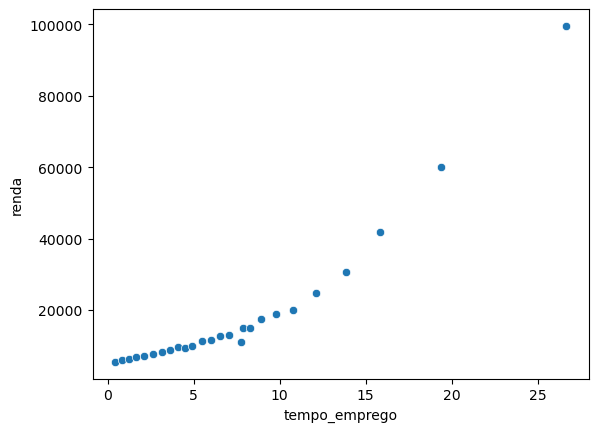

In [19]:
# Visualização do gráfico da tabela
sns.scatterplot(data=tabela, x = 'tempo_emprego', y = 'renda')

In [20]:
# Modelo de regressão linear utiliando o OLS antes dos agrupementos
res = smf.ols('renda ~ tempo_emprego', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 4.087e+05
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:18:07   Log-Likelihood:            -8.5511e+06
No. Observations:              742497   AIC:                         1.710e+07
Df Residuals:                  742495   BIC:                         1.710e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6274.8423     46.796   -134.089

In [21]:
res = smf.ols('renda ~ tempo_emprego',data=tabela).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     184.0
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           9.51e-13
Time:                        16:18:08   Log-Likelihood:                -266.56
No. Observations:                  26   AIC:                             537.1
Df Residuals:                      24   BIC:                             539.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4863.8140   2234.023     -2.177

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

Ao observar todos os R² dos modelos criados, é possível observar que a linearização realizada após os agrupamentos foi a com maior R².
As linearizações segmentada e Lowess tem os valores de R² proximo e não são as melhores.